## Group Level Analysis

In [1]:
import os
os.chdir("..")

from agents.utils import create_bins, discretize_observation
from scipy import stats
from ast import literal_eval

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import pandas as pd
import json
import ast

In [6]:
def read_json_log(log):
    with open(log, "rb") as f:
        log = json.load(f)
    return log
    
def json_array_to_list(arr):
    return ast.literal_eval(arr)


def score_datapoints(arr):
    mu = np.mean(arr)
    sigma = np.std(arr)
    return np.abs(arr - mu) < sigma

def calculate_snr(log):
    if isinstance(log, str):
        log = read_json_log(log)
    reward = np.array(json_array_to_list(log[-1]["reward"]))
    return reward.mean() / reward.std()

def pad_to_max_length(arr, max_length):
    return np.pad(arr, (0, max_length - len(arr)), mode='constant', constant_values=0)

def plot_reward(logs):
    reward_arrays = []
    convergence_arrays = []
    SNRs = []
    sizes = []
    processed_logs_data = []

    for log_path in logs:
        if not os.path.exists(log_path):
            continue
        try:
            log_data = read_json_log(log_path)
            processed_logs_data.append(log_data)
            reward = json_array_to_list(log_data[-1]["reward"])
            sizes.append(len(reward))
        except Exception:
            continue

    if not sizes:
        return

    max_length = np.max(sizes)
    min_length = np.min(sizes)

    for log_data in processed_logs_data:
        try:
            reward = json_array_to_list(log_data[-1]["reward"])
            convergence = json_array_to_list(log_data[-1]["convergence"])
            SNRs.append(np.float16(calculate_snr(log_data)))
            reward_arrays.append(pad_to_max_length(reward, max_length))
            convergence_arrays.append(pad_to_max_length(convergence, max_length))
        except Exception:
            continue


    if not reward_arrays:
         return
    reward_log_stack = np.vstack(reward_arrays)
    convergence_log_stack = np.vstack(convergence_arrays)

    mean_snr = np.mean(SNRs) if SNRs else np.nan
    df = pd.DataFrame(columns=["trial", "reward", "convergence"])
    df["trial"] = np.arange(min_length)
    df["reward"] = np.mean(reward_log_stack[:, :min_length], axis=0)
    df["convergence"] = np.mean(convergence_log_stack[:, :min_length], axis=0)

    df_filtered = df[score_datapoints(df["reward"])].copy()
    if df_filtered.empty:
        return

    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    fig.suptitle("Mean reward & convergence", fontsize=18)

    sns.regplot(x="trial", y="reward", data=df_filtered, color="black", ax=axes[0])
    axes[0].set_xlabel(None) # Explicitly remove xlabel for top plot
    axes[0].set_ylabel("Mean Reward", fontsize=14)
    axes[0].tick_params(axis='y', labelsize=12)
    axes[0].set_title(f"Mean SNR: {mean_snr:.2f}, Kernel Sigma: 4.0", fontsize=14)

    sns.regplot(x="trial", y="convergence", data=df_filtered, color="black", ax=axes[1])
    axes[1].set_xlabel("Trials", fontsize=14) # Removed common range info
    axes[1].set_ylabel("Mean Convergence", fontsize=14)
    axes[1].tick_params(axis='x', labelsize=12)
    axes[1].tick_params(axis='y', labelsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def get_q_table_max(log, table_size):
    maxima = []
    for table in log:
        q_table = json_array_to_list(table["q_table"])
        maxima.append(np.unravel_index(np.argmax(q_table), table_size))
    return maxima

def get_q_table_steps(log, num_bins):
    steps = []
    for data in log:
        contrast = data["contrast"]
        frequency = data["frequency"]
        bins = create_bins(num_bins)
        steps.append(discretize_observation([contrast, frequency], bins))
    return steps

def plot_q_table_steps(logs):
    tables = []
    x_step_log = []
    y_step_log = []
    x_max_log = []
    y_max_log = []
    sizes = []

    for log in logs:
        log = read_json_log(log)
        sizes.append(len(log))

    max_length = np.max(sizes)
    min_length = np.min(sizes)

    for log in logs:
        log = read_json_log(log)
        step = np.array(get_q_table_steps(log, 10))
        cur_max = np.array(get_q_table_max(log, (10, 10))) # adjust discretization;

        if len(tables) == 0:
            tables = np.array(json_array_to_list(log[-1]["q_table"])).flatten()
            
            x_step_log = pad_to_max_length(np.array(step[:, 0]), max_length)
            y_step_log = pad_to_max_length(np.array(step[:, 1]), max_length)
            
            x_max_log = pad_to_max_length(cur_max[:, 0], max_length)
            y_max_log = pad_to_max_length(cur_max[:, 1], max_length) 
        else:
            tables = np.vstack((tables, np.array(json_array_to_list(log[-1]["q_table"])).flatten()))
            
            x_step_log = np.vstack((x_step_log, pad_to_max_length(step[:, 0], max_length)))
            y_step_log = np.vstack((y_step_log, pad_to_max_length(step[:, 1], max_length)))
            
            x_max_log = np.vstack((x_max_log, pad_to_max_length(cur_max[:, 0], max_length)))
            y_max_log = np.vstack((y_max_log, pad_to_max_length(cur_max[:, 1], max_length)))

    last_table = np.mean(tables, axis=0).reshape(10, 10)
    maxima = np.vstack([np.mean(x_max_log, axis=0), np.mean(y_max_log, axis=0)]).reshape(-1, 2).astype(int)
    steps = np.random.randint(0, len(maxima), len(maxima))

    plt.imshow(last_table)
    plt.xlabel("Frequency", fontsize=16)
    plt.ylabel("Contrast", fontsize=16)
    plt.colorbar().set_label("Q-value", fontsize=16)
    plt.plot(maxima[:, 1], maxima[:, 0], "--", alpha=0.4)
    plt.scatter(maxima[:, 1], maxima[:, 0], c=steps, cmap='plasma', alpha=0.5)
    plt.colorbar().set_label("Trial number", fontsize=16)
    plt.title(f"Real-time fMRI", fontsize=20)
    plt.show()


### Plot mean reward and convergence (all runs)

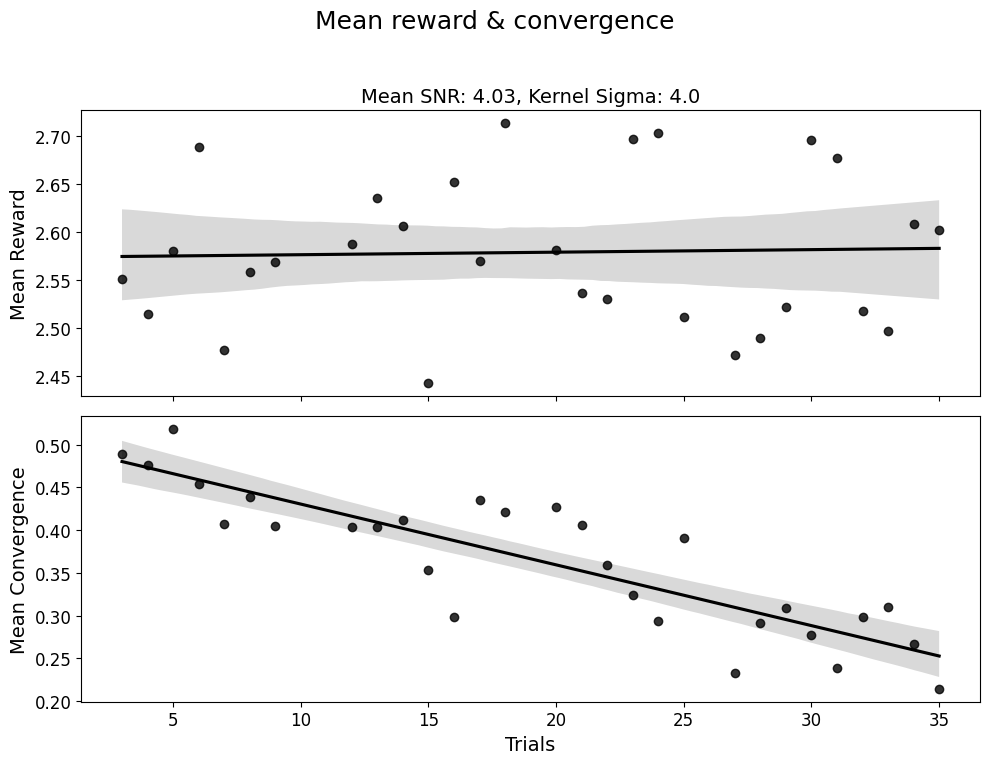

In [7]:
# plot reward;
subjects = ["sub-001", "sub-002", "sub-003", "sub-004", "sub-005", "sub-006", "sub-007", "sub-008", "sub-009", "sub-010"]
datapoints = ["data_1", "data_2"]
logs = [f"./data/{sub}/{data}/log/log.json" for sub in subjects for data in datapoints]
plot_reward(logs)

### Plot mean Q-table

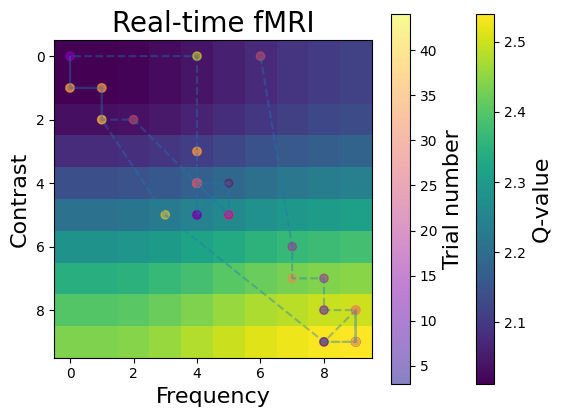

In [3]:
subjects = ["sub-001", "sub-002", "sub-003", "sub-004", "sub-005", "sub-006", "sub-007", "sub-008", "sub-009", "sub-010"]
datapoints = ["data_1", "data_2"]
logs = [f"./data/{sub}/{data}/log/log.json" for sub in subjects for data in datapoints]
plot_q_table_steps(logs)

### Average Prediction error with some statistics

The following functions also report:

- mean improvement across trials
- mean improvement from chance level
- mean frequency (full timeframe)
- mean frequency till 5min

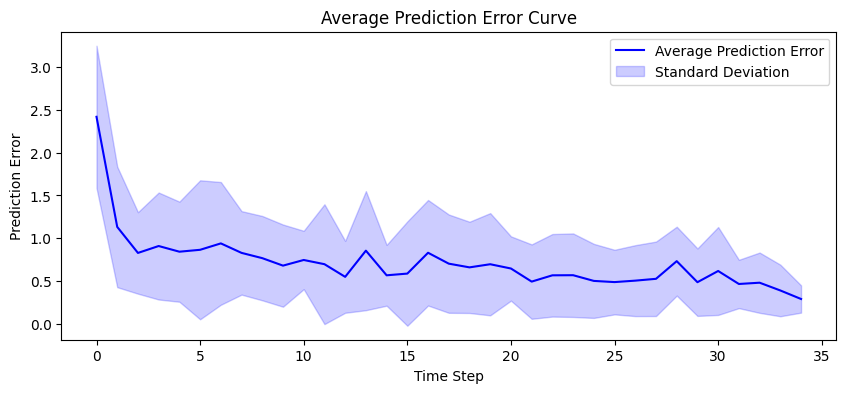

mean improvement: 17.05093196561485%
from chance level: 88.06691635535469%
mean frequency (full timeframe): 18.3Hz (SD: 10.257192598367256Hz)
mean frequency till 5min: 10.8Hz (SD: 12.089665007765932Hz)


In [17]:
# Function to compute prediction error curve for a single run
def calculate_prediction_error(log_data):
    # Initialize lists to store q_values and actions
    q_values = []
    rewards = []
    current_actions = []

    for i in range(len(log_data)):
        current_action = log_data[i]["current action"]

        if i == 0 and current_action is None:
            q_value = 0
            current_action = [0, 0]
        else:
            q_table = np.array(literal_eval(log_data[i - 1]["q_table"]))
            q_table = q_table.reshape(10, 10)

            current_action = literal_eval(current_action)
            if current_action[0] == 1.0:
                current_action[0] = 0.9
            
            if current_action[1] == 1.0:
                current_action[1] = 0.9

            q_value = q_table[int(current_action[0]*10), int(current_action[1]*10)]  # Using the current_action to pick the Q-value

        reward = literal_eval(log_data[-1]["reward"])[i - 1]
        convergence = literal_eval(log_data[-1]["convergence"])[:35]
        frequency = log_data[-1]["frequency"]

        q_values.append(q_value)
        rewards.append(reward)
        current_actions.append(current_action)

    # Calculate prediction errors: Q-value at time t minus reward at time t+1;
    prediction_errors = np.abs(np.array(q_values) - np.array(rewards))

    return frequency, prediction_errors, convergence


# Function to process data for all subjects and runs;
def process_subject_data(subject_dir):
    prediction_errors_all_runs = []
    frequency_all_runs = []
    conv_all_runs = []

    for run in ["data_1", "data_2"]:
        run_dir = os.path.join(subject_dir, run, "log")  # log folder inside data_1/data_2
        log_path = os.path.join(run_dir, "log.json")

        # Load JSON data
        with open(log_path, 'r') as f:
            log_data = json.load(f)

        # Calculate prediction error curve for the run
        frequency, prediction_errors, convergence = calculate_prediction_error(log_data)
        prediction_errors_all_runs.append(prediction_errors)
        frequency_all_runs.append(frequency)
        conv_all_runs.append(convergence)

    return frequency_all_runs, prediction_errors_all_runs, conv_all_runs


# Function to plot average prediction error with 95% CI or STD;
def plot_avg_prediction_error(all_prediction_errors, steps=30):
    # Stack all prediction errors into a 2D array (subjects x timepoints)
    for idx, pe in enumerate(all_prediction_errors):
        if idx == 0:
            all_pe = pe[:35]
        else:
            all_pe = np.vstack((all_pe, pe[:steps]))

    mean_prediction_error = np.mean(all_pe, axis=0)

    # with std;
    ci_lower = mean_prediction_error - all_pe.std(axis=0)
    ci_upper = mean_prediction_error + all_pe.std(axis=0)

    # 95% confidence internvals;
    # ci_lower = np.percentile(all_pe, 2.5, axis=0)
    # ci_upper = np.percentile(all_pe, 97.5, axis=0)

    # Plotting
    timepoints = np.arange(mean_prediction_error.shape[0])

    plt.figure(figsize=(10, 4))
    plt.plot(timepoints, mean_prediction_error, label="Average Prediction Error", color='b')
    plt.fill_between(timepoints, ci_lower, ci_upper, color='b', alpha=0.2, label="Standard Deviation")
    plt.xlabel('Time Step')
    plt.ylabel('Prediction Error')
    plt.title('Average Prediction Error Curve')
    plt.legend()
    plt.savefig('foo.png')

    plt.show()

    return mean_prediction_error


def calculate_percentage_improvement(timeseries):
    timeseries = np.array(timeseries)
    improvements = (np.abs(np.diff(timeseries)) / timeseries[:-1]) * 100
    return improvements


# Main processing function;
def main():
    data_path = "./data/"

    all_prediction_errors = []
    all_frequencies = []
    all_convergencies = []

    # Loop through each subject folder
    for subject_folder in os.listdir(data_path):
        subject_dir = os.path.join(data_path, subject_folder)
        if os.path.isdir(subject_dir):
            # Process data for this subject
            frequency_all_runs, prediction_errors_all_runs, conv_all_runs = process_subject_data(subject_dir)

            # Concatenate prediction errors for both runs (data_1 and data_2)
            for prediction_errors in prediction_errors_all_runs:
                all_prediction_errors.append(prediction_errors)

            for frequencies in frequency_all_runs:
                all_frequencies.append(frequencies)

            for convergencies in conv_all_runs:
                all_convergencies.append(convergencies)

    # Plot the results
    mean_pe = plot_avg_prediction_error(all_prediction_errors, steps=35)
    mean_frequency = np.array(all_frequencies).mean()
    mean5_frequency = np.array(all_frequencies[15:25]).mean()
    std_frequency = np.array(all_frequencies).std()
    std5_frequency = np.array(all_frequencies[15:25]).std()
    
    percentage_improvements = calculate_percentage_improvement(mean_pe)
    from_chance_level = (abs(mean_pe[-1] - mean_pe[0]) / mean_pe[0]) * 100
    
    print(f"mean improvement: {percentage_improvements.mean()}%" )
    print(f"from chance level: {from_chance_level}%")
    print(f"mean frequency (full timeframe): {mean_frequency * 30}Hz (SD: {std_frequency * 30}Hz)")
    print(f"mean frequency till 5min: {mean5_frequency * 30}Hz (SD: {std5_frequency * 30}Hz)")

    return mean_pe

# calculate avg mape and statistics;
mean_pe = main()

### Calculate average mean absolute percentage error (avg MAPE)

In [2]:
import os
import json
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm
from ast import literal_eval

def run_glm(y, x):
    regressors = x
    regressors = sm.add_constant(regressors)
    model = sm.OLS(y, regressors).fit()

    # test multiple regression;
    alpha = model.params[0]
    beta = model.params[1]
    return alpha, beta

def mean_absolute_percentage_error(log_data):
    all_mape = []
    for i in range(len(log_data)):
        if i == 0:
            hrf = np.array(literal_eval(log_data[0]["hrf"]))
            reward = np.array(literal_eval(log_data[-1]["reward"]))
            n_trials = len(log_data)
        else:
            q_table = np.array(literal_eval(log_data[i]["q_table"])).reshape(10, 10)
            action = np.array(literal_eval(log_data[i]["current action"]))
            fmridata = np.array(literal_eval(log_data[i]["fmri_data"]))

            # clip action max values to avoid going out of bounds;
            if action[0] == 1.0:
                action[0] = 0.9

            if action[1] == 1.0:
                action[1] = 0.9

            q_val = q_table[int(action[0]*10), int(action[1]*10)]
            #alpha, beta = run_glm(hrf, fmridata)
            #reward = (beta / alpha) * 100

            all_mape.append( abs(( reward[i - 1] - q_val) / reward[i - 1] ) )

    return all_mape

data_path = "./data"
mape = []
steps = 35

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)

    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Construct the paths for data_1/log and data_2/log
        data_1_log_path = os.path.join(folder_path, "data_1/log", "log.json")
        data_2_log_path = os.path.join(folder_path, "data_2/log", "log.json")

        # Read log.json from data_1
        if os.path.exists(data_1_log_path):
            with open(data_1_log_path, "r") as file_1:
                log_data_1 = json.load(file_1)
                score = mean_absolute_percentage_error(log_data_1)
                if len(mape) == 0:
                    mape = score[:steps]
                else:
                    mape = np.vstack((mape, score[:steps]))

        # Read log.json from data_2
        if os.path.exists(data_2_log_path):
            with open(data_2_log_path, "r") as file_2:
                log_data_2 = json.load(file_2)
                score = mean_absolute_percentage_error(log_data_2)
                if len(mape) == 0:
                    mape = score[:steps]
                else:
                    mape = np.vstack((mape, score[:steps]))

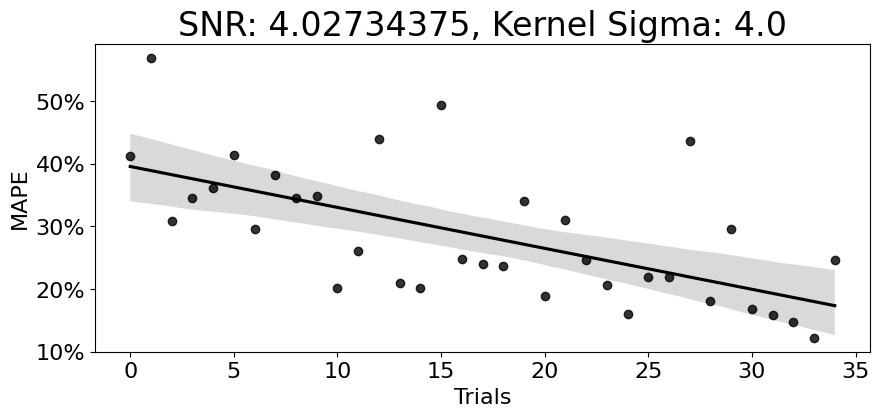

In [3]:
mean_mape = mape.mean(axis=0)

df = pd.DataFrame()
df["mape"] = mean_mape * 100
df["idx"] = np.arange(len(mean_mape))

def percent(x, pos):
    return f'{x:.0f}%'

fig, ax = plt.subplots(figsize=(10, 4))

sns.regplot(x="idx", y="mape", data=df, color="k", ax=ax)

formatter = mtick.FuncFormatter(percent)
ax.yaxis.set_major_formatter(formatter)

plt.xlabel("Trials", fontsize=16)
plt.ylabel("MAPE", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title(f"SNR: {4.02734375}, Kernel Sigma: 4.0", fontsize=24)

plt.savefig("error_percentage.png")
plt.show()